## 1. Business understanding
- Our goal is:
    1. to find optimal locations for drone hub stations
    2. To find interesting  relationships between variables / products.

### Expectations
- We expect to find optimal locations for the hub stations from the data in a way that it can be represented easily.
- The same goes for the second task. We expect to find relationships between the variables which the company can utilize in their marketing / sales.

## 2. Data understainding
### Dataset: drone_cust_locations
- There are three variables: CustomerId, x and y. CustomerId is self-explanatory, x and y are locations when plotted into a 2D plane.

- The data has no null values and has correct format for the next steps. => Data has no quality issues.

### Dataset: drone_prod_groups
- ID = transactionID
- Prod1, ..., Prod20 - Binary variables indicating whether at least one product from a particular group was purchased in the transaction. A value of 1 indicates that at least one product from the group was purchased, while a value of 0 indicates that no products from the group were purchased.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.vq import kmeans

df = pd.read_csv("drone_cust_locations.csv", sep=';')
df.head()

,clientid,x,y
0,1,622.771572,164.857623
1,2,416.357298,630.193634
2,3,292.735020,567.333231
3,4,737.211288,166.225676
4,5,540.475375,682.912298


In [7]:
df.describe()

,clientid,x,y
count,5956.000000,5956.000000,5956.000000
mean,2978.500000,508.823177,427.554772
std,1719.493433,271.061462,289.044640
min,1.000000,0.017692,0.043285
25%,1489.750000,282.582920,170.079921
50%,2978.500000,518.100892,397.786441
75%,4467.250000,727.156497,669.982518
max,5956.000000,999.533215,999.731720


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956 entries, 0 to 5955
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   clientid  5956 non-null   int64  
 1   x         5956 non-null   float64
 2   y         5956 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 139.7 KB


In [9]:
print(df.isnull().sum())

clientid    0
x           0
y           0
dtype: int64


## 3. Data preparation
- The first dataset didn't need any cleaning. the variable values are in correct form.

## 4. Modeling
### We are using the K-means algorithm.
- Preparing the data for clustering by giving them to the variable X.
- You can find the map below. It shows the three clusters and their center points. Those are the optimal locations for the HUBs.

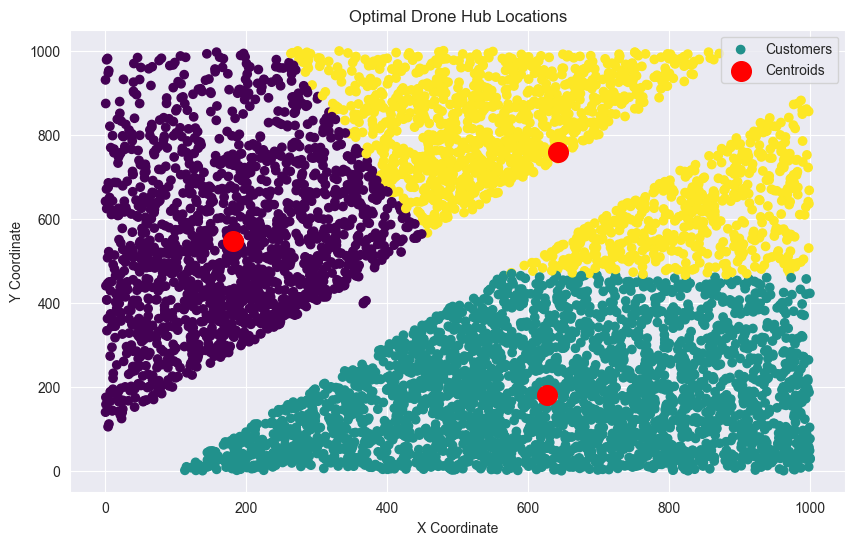

In [27]:
from sklearn.cluster import KMeans
X = df[['x','y']]

model = KMeans(n_clusters=3, random_state=42)
model.fit(X)
df['cluster']= model.labels_

centroids = model.cluster_centers_
plt.figure(figsize=(10, 6))
plt.scatter(df['x'], df['y'], c=df['cluster'], cmap='viridis', marker='o', label='Customers')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='o', s=200, label='Centroids')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Optimal Drone Hub Locations')
plt.legend()
plt.show()

# To do:
Piirrä kartta mikä havainnollistaa asiakkaiden sijainteja

